## Load Data

In [24]:
import json
import string
import matplotlib.pyplot as plt 
import json_lines
import itertools

with open('result.jl', 'rb') as f:
    entities = [x for x in json_lines.reader(f)]
    stories = [x for x in entities if str(x['pageType']) == "story" and str(x['storyType']) == '/book/Harry-Potter/']
    storiesNotPotter = [x for x in entities if str(x['pageType']) == "story" and str(x['storyType']) != '/book/Harry-Potter/']
    reviews = [x for x in entities if str(x['pageType']) == "review"]
    users = [x for x in entities if str(x['pageType']) == "user"]
    
    print(len(stories),len(storiesNotPotter),len(reviews),len(users))

1798 3693 46479 1655


## Display Sentiment chart

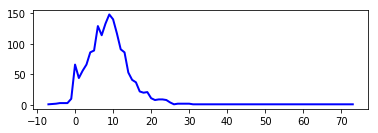

In [4]:
import operator
storyReviewDic = {}
for review in reviews:
    if(review['reviewOf'] not in storyReviewDic):
        storyReviewDic[review['reviewOf']] = []
    storyReviewDic[review['reviewOf']].append(review)

storySentimentScores = [sum([z['sentimentScore'] for z in y]) for x, y in storyReviewDic.items()]

buckets = {}

def updateBucket(x):
    buckets.setdefault(x, 0)
    buckets[x]+=1

[ updateBucket(int(x)) for x in storySentimentScores]

sortedBuckets = sorted(buckets.items(), key=operator.itemgetter(0))

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot([x for x,y in sortedBuckets], [y for x,y in sortedBuckets], color='blue', lw=2)

#print(sum(storySentimentScore)/ len(storySentimentScore))

In [5]:
sum(storySentimentScores)/len(storySentimentScores)

9.344541108404393

## Create Adjacency Matrix

In [28]:
import numpy as np
idDict = {}
idCnt = 0

for x in users:
    if(x['name'] in idDict):
        continue;
    idDict[idCnt] = x['name']
    idCnt += 1

nameToIdDict = {v: k for k, v in idDict.items()}

userFavorites = {}
for user in users:
    userId = nameToIdDict[user['name']]
    userFavorites[userId] = []
    for favorite in user['favorites']:
        auther = favorite['favAuthor']
        if(auther in nameToIdDict):
            autherId = nameToIdDict[auther]
            if(autherId not in userFavorites[userId]):
                userFavorites[userId].append(autherId)
                
matrix = np.zeros([len(idDict), len(idDict)])

for userId, favorites in userFavorites.items():
    matrix[userId, userId] = 1
    for favId in favorites:
        matrix[userId, favId] = 1

## Try to get groups based on adjacency matrix

In [7]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

random_state = 345345
pred = KMeans(n_clusters=5, random_state=random_state).fit_predict(matrix)

i = 0
clusters = {}
def makeCombined(x):
    global i
    row = [i,x]
    i += 1
    return row

usersWithCluster = [makeCombined(x) for x in pred]

import collections

clusters = collections.defaultdict(list)
for x in usersWithCluster:
    clusters[x[1]].append(x[0])
clusters = dict(clusters)
print([len(j) for i,j in clusters.items()])

<Figure size 864x864 with 0 Axes>

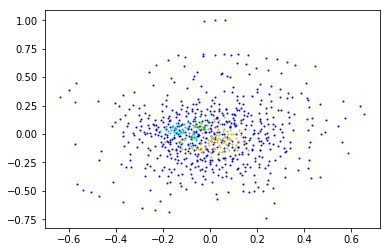

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

colors = ['r', 'b', 'y', 'g', 'c', 'black', 'm', 'orange', 'grey', '']

def show_graph(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    #print([x for x in edges])
    gr = nx.Graph()
    gr.add_edges_from(edges)
    #gr[0][1]['color'] = 'color'
    
    #nx.draw(gr, node_size=1)
    pos=nx.spring_layout(gr) 
    for i in range(5):
        nx.draw_networkx_nodes(gr,pos,nodelist = clusters[i], node_size=1, node_color=colors[i])
    #nx.draw_networkx_nodes(gr,pos,nodelist = clusters[1], node_size=1, node_color=colors[1])
    
    #nx.draw_networkx_edges(gr,pos,
    #                   width=1,alpha=0.5,edge_color='r')
    plt.show()
    
show_graph(matrix)


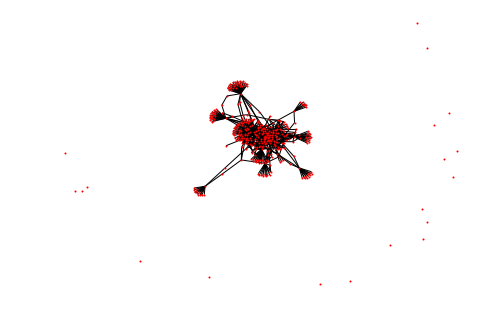

In [135]:
import matplotlib.pyplot as plt
import networkx as nx

def show_graph(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    
    nx.draw(gr, node_size=1)
    plt.show()
    
show_graph(matrix)

## Make Character Graph

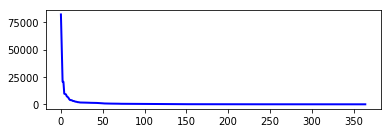

In [3]:
import collections
from collections import Counter
characterFreqs = Counter({})
for x in stories:
    characterFreqs += Counter(x['characters'])
characterFreqs = dict(characterFreqs)
#print(characterFreqs)
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(sorted(characterFreqs.values(), reverse=True), color='blue', lw=2)

## making character matrix 

### get character ids

In [195]:
import collections
from collections import Counter
characterFreqs = Counter({})
for x in stories:
    characterFreqs += Counter(x['characters'])
characterFreqs = dict(characterFreqs)
charList = list(characterFreqs.keys())
idToChar = {charList.index(x): x for x in charList}
charToId = {x : charList.index(x) for x in charList}

### make the matrix

In [196]:
import numpy as np
from numpy import linalg as LA

matrix = np.zeros([len(stories), len(charToId)])

storyId = 0
for story in stories:
    totalCharFreq = 0
    chars = dict(story['characters'])
    for char, freq in chars.items():
    #    if(char != 'Harry Potter' and char != 'Ron weasley'):
        totalCharFreq += freq
    for char, freq in chars.items():
    #    if(char != 'Harry Potter' and char != 'Ron weasley'):
        matrix[storyId][charToId[char]] = freq
        #else:
        #    matrix[storyId][charToId[char]] = 0
    storyId += 1
matrix = (matrix / matrix.sum())


### cluster it

In [197]:
import time
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

random_state = int(time.time())
pred = KMeans(n_clusters=20, random_state=random_state).fit_predict(matrix)

In [198]:
i = 0
clusters = {}
def makeCombined(x):
    global i
    row = [i,x]
    i += 1
    return row

storiesWithCluster = [makeCombined(x) for x in pred]
#print(sotriesWithCluster)


In [203]:
import collections

clusters = collections.defaultdict(list)
for x in storiesWithCluster:
    clusters[x[1]].append(x[0])
clusters = dict(clusters)
#print(clusters)
print([(i,len(j)) for i,j in clusters.items()])

[(9, 68), (0, 305), (2, 221), (17, 183), (4, 110), (7, 80), (1, 26), (19, 23), (13, 1117), (8, 30), (5, 5), (11, 7), (12, 4), (3, 3), (10, 5), (6, 7), (14, 6), (16, 1), (18, 1), (15, 1)]


In [204]:
def showCluster(clusterId):
    clusterCharacterFreqs = Counter({})
    for storyId in clusters[clusterId]:
        charsInStory = np.where(matrix[storyId] > 0)
        if(len(charsInStory[0]) == 0):
            continue
        for charId in np.nditer(charsInStory):
            #print(matrix[storyId][charId], charId)
            clusterCharacterFreqs[int(charId)] += matrix[storyId][charId]
    clusterCharsWithFreq = [(x,y, idToChar[x])for x,y in clusterCharacterFreqs.items() if y > .002]
    
    return sorted(clusterCharsWithFreq, key= lambda x: x[1],reverse=True)

print(clusters.keys())
    
for i in clusters.keys():
    #print(len(clusters[i]))
    print(i,[ (z,int(y*1000)) for x,y,z in showCluster(i)])

dict_keys([9, 0, 2, 17, 4, 7, 1, 19, 13, 8, 5, 11, 12, 3, 10, 6, 14, 16, 18, 15])
9 [('Harry Potter', 35), ('Ron weasley', 9), ('Albus Dumbledore', 3), ('Voldemort', 3), ('Cho Chang', 3), ('Death', 2), ('Hermione Granger', 2), ('Ginny weasley', 2), ('Severus Snape', 2)]
0 [('Harry Potter', 30), ('Ron weasley', 14), ('Hermione Granger', 9), ('Cho Chang', 5), ('Albus Dumbledore', 4), ('Severus Snape', 3), ('Voldemort', 3), ('Draco Malfoy', 2), ('Death', 2), ('Fat Friar', 2)]
2 [('Ron weasley', 26), ('Cho Chang', 9), ('Fat Friar', 4), ('Death', 2), ('Michael Corner', 2), ('Hope Howell', 2), ('Dean Thomas', 2), ('Ben Cooper', 2), ('Severus Snape', 2)]
17 [('Harry Potter', 37), ('Ron weasley', 11), ('Hermione Granger', 6), ('Cho Chang', 5), ('Albus Dumbledore', 4), ('Voldemort', 3), ('Death', 2), ('Severus Snape', 2), ('Remus Lupin', 2)]
4 [('Harry Potter', 38), ('Ron weasley', 8), ('Cho Chang', 3), ('Hermione Granger', 3), ('Severus Snape', 3), ('Ginny weasley', 2), ('Voldemort', 2), ('Alb

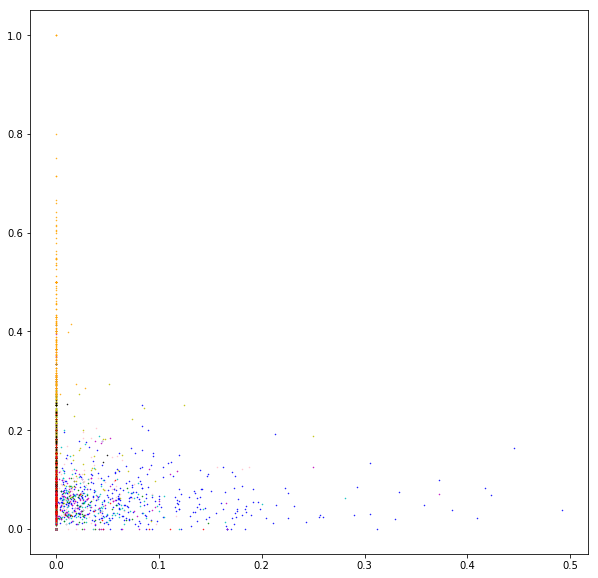

In [137]:
import matplotlib.pyplot as plt
import networkx as nx

colors = ['r', 'b', 'y', 'g', 'c', 'black', 'm', 'orange', 'grey', 'pink']

def plotCharacters(charId1, charId2, clusters):
    #print(charId1, charId2, clusters)
    #print(clusters)
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(1, 1, 1)
    for clusterId, cluster in clusters.items():
        X = []
        Y = []
        for storyId in cluster:
            X.append(matrix[storyId][charId1])
            Y.append(matrix[storyId][charId2])
        ax.scatter(X,Y, color=colors[clusterId], s=.25)
            
plotCharacters(2,4, clusters)

## LDA

### Characters in Story

In [89]:
def foldDict(chars):
    charsMult = [(char + ' ') * freq for char, freq in chars.items()]
    #print(len(charsMult))
    charsStr = ''
    for charStr in charsMult:
        charsStr += charStr
    return charsStr

charList = [ foldDict(story['characters']) for story in stories]

1798


In [91]:
from __future__ import print_function

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_features = 5000
n_topics = 20
n_top_words = 10

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print("Loading dataset...")

train = charList

print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=10,
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(train)
print("Fitting LDA model ...")
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20,
                                learning_method='online',
                                learning_offset=50.)

lda.fit(tf)

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
Extracting tf features for LDA...
Fitting LDA model ...

Topics in LDA model:

Topic #0:
malfoy draco lucius narcissa blaise zabini fat friar hermione granger

Topic #1:
tracey davis fenrir greyback johnson angelina greengrass astoria alicia spinnet

Topic #2:
bones cornelilus fudge susan amelia flint marcus albus dumbledore scrimgeour

Topic #3:
snape severus dumbledore albus fat friar pomfrey poppy howell hope

Topic #4:
nott theodore evans mark filius flitwick ben cooper roper sophie

Topic #5:
gaunt riddle tom death jr merope quirinus quirrell marvolo friar

Topic #6:
granger hermione dobby howell hope fat friar lavender brown voldemort

Topic #7:
hagrid rubeus diggory cedric albus bagman ludo dumbledore karkaroff igor

Topic #8:
delacour fleur viktor krum vane romilda gabrielle maxime olympe fat

Topic #9:
ginny weasely arthur percy shacklebolt kingsley fred granger death molly

Topic #10:
dursley dudley vernon petunia hedwig friar fat figg arabella hope

Topic 

### Do Story Text

In [69]:
storiesText = [x['abstract'] for x in stories]

In [70]:
from __future__ import print_function

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_features = 5000
n_topics = 20
n_top_words = 10

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print("Loading dataset...")

train = storiesText

print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.7, min_df=10,
                                max_features=n_features,
                                stop_words='english')
#tf_vectorizer = CountVectorizer(max_features=n_features)


tf = tf_vectorizer.fit_transform(train)
print("Fitting LDA model ...")
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20,
                                learning_method='online',
                                learning_offset=50.)

lda.fit(tf)

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
Extracting tf features for LDA...
Fitting LDA model ...

Topics in LDA model:

Topic #0:
year hermione hogwarts story time au ron decides voldemort years

Topic #1:
weasley secrets chamber fawkes diary chapters day hermione finally late

Topic #2:
draco really love got person malfoy hermione point mate parents

Topic #3:
friends place complete family year change like summer events hermione

Topic #4:
discovers deal lot daphne plan triwizard unexpected potter goblet umbridge

Topic #5:
dark hp little dumbledore lord hogwarts death set just hermione

Topic #6:
luna battle final come day way help tom dear adopted

Topic #7:
reviews saving voldemort ron leave discovers hogwarts tries training took

Topic #8:
sirius black ootp fight death dimension able au forever avoid

Topic #9:
life make finds gets changes potter slash shot home summer

Topic #10:
things potter world past magical don chance change didn war

Topic #11:
time travel future bond fic bonds power soul voldem

### Do Review Text

In [65]:


storiesDict = {x['storyLink'] : x for x in stories}

#print(len(reviewsText))
#print(len[x for x in reviews[:110]])
#print(len())
harryPotterReviews = [x for x in reviews if x['reviewOf'] in storiesDict]
reviewsText = [x['reviewBody'] for x in harryPotterReviews]
#and storiesDict[x['reviewOf']]['storyType']] == '/book/Harry-Potter/'
#print([x['storyLink'] for x in stories[:1]])

In [68]:
from __future__ import print_function

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_features = 5000
n_topics = 10
n_top_words = 10

print("Loading dataset...")

train = reviewsText[:1000]

print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=10,
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(train)
print("Fitting LDA model ...")
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20,
                                learning_method='online',
                                learning_offset=50.)

lda.fit(tf)

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
Extracting tf features for LDA...
Fitting LDA model ...

Topics in LDA model:

Topic #0:
story read like really im just love thanks writing ive

Topic #1:
love oh dumbledore voldemort youre stop death sirius right harrys

Topic #2:
nice chapter cute lol damn new far got fanfic thats

Topic #3:
harry hermione like ron think draco way liked know things

Topic #4:
update great soon hope family chapter hello going magic story

Topic #5:
finish come end years wait ending need read good leave

Topic #6:
read interesting wow fic continue thing reread reading potter definitely

Topic #7:
good just did sad brilliant poor getting thats snape chapter

Topic #8:
story loved excellent continue great really quite hope let dont

Topic #9:
thank writing stories awesome work didnt think lot amazing beautiful

